<a href="https://colab.research.google.com/github/Skorobogatchenko2004/sumo/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Materials_for_lection_2_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyro-ppl

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
from pyro import distributions as dist
from pyro import poutine

%matplotlib inline

Пример семплирования из распределения:

In [ ]:
a = pyro.sample("a", dist.Uniform(0, 10))
a

tensor(0.5028)

Расчет вероятности, с которой сгенерируется данный семпл из рассматриваемого распределения:

In [ ]:
x = torch.tensor(-20)

print("log probability: ", np.exp(dist.Normal(0, 1).log_prob(x)))

log probability:  tensor(0.)


Рассмотрим задачу оценки количества выпадения орлов при 1000 бросках монеты.

$h = \mathcal{N}(0, 1)$

$y = \mathcal{Bin}(1000, \sigma(h))$

In [ ]:
def model():
    head_logits = pyro.sample("head_logits",
                              dist.Normal(0.0 * torch.ones(20000), 1.0))
                              #dist.Uniform(-1.0 * torch.ones(20000), 1.0))
    coins_outcomes = pyro.sample("coins_outcomes",
                                 dist.Binomial(1000, logits=head_logits))
    return coins_outcomes

In [ ]:
model()

tensor([386., 438., 503.,  ..., 307., 677., 735.])

Визуализируем графическую модель:

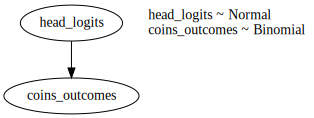

In [ ]:
pyro.render_model(model, model_args=(None),
                  render_distributions=True, render_params=True)

Выполним семплирование и сохраним результаты как "трассу":

In [ ]:
trace = poutine.trace(model).get_trace()

In [ ]:
trace

И посмотрим на неё:

In [ ]:
for name, site in trace.nodes.items():
    print(name)
    print(site)

_INPUT
{'name': '_INPUT', 'type': 'args', 'args': (), 'kwargs': {}}
head_logits
{'type': 'sample', 'name': 'head_logits', 'fn': Normal(loc: torch.Size([20000]), scale: torch.Size([20000])), 'is_observed': False, 'args': (), 'kwargs': {}, 'value': tensor([ 0.0675,  0.5048, -0.0579,  ..., -0.2280, -1.7509, -0.7024]), 'infer': {}, 'scale': 1.0, 'mask': None, 'cond_indep_stack': (), 'done': True, 'stop': False, 'continuation': None}
coins_outcomes
{'type': 'sample', 'name': 'coins_outcomes', 'fn': Binomial(total_count: torch.Size([20000]), probs: torch.Size([20000]), logits: torch.Size([20000])), 'is_observed': False, 'args': (), 'kwargs': {}, 'value': tensor([519., 646., 492.,  ..., 420., 126., 359.]), 'infer': {}, 'scale': 1.0, 'mask': None, 'cond_indep_stack': (), 'done': True, 'stop': False, 'continuation': None}
_RETURN
{'name': '_RETURN', 'type': 'return', 'value': tensor([519., 646., 492.,  ..., 420., 126., 359.])}


Нормирование logit'ов в вероятности:

In [ ]:
def sigma(x):
    return (1.0 / (1.0 + np.exp(-x)))

Визуализация основных распределений:

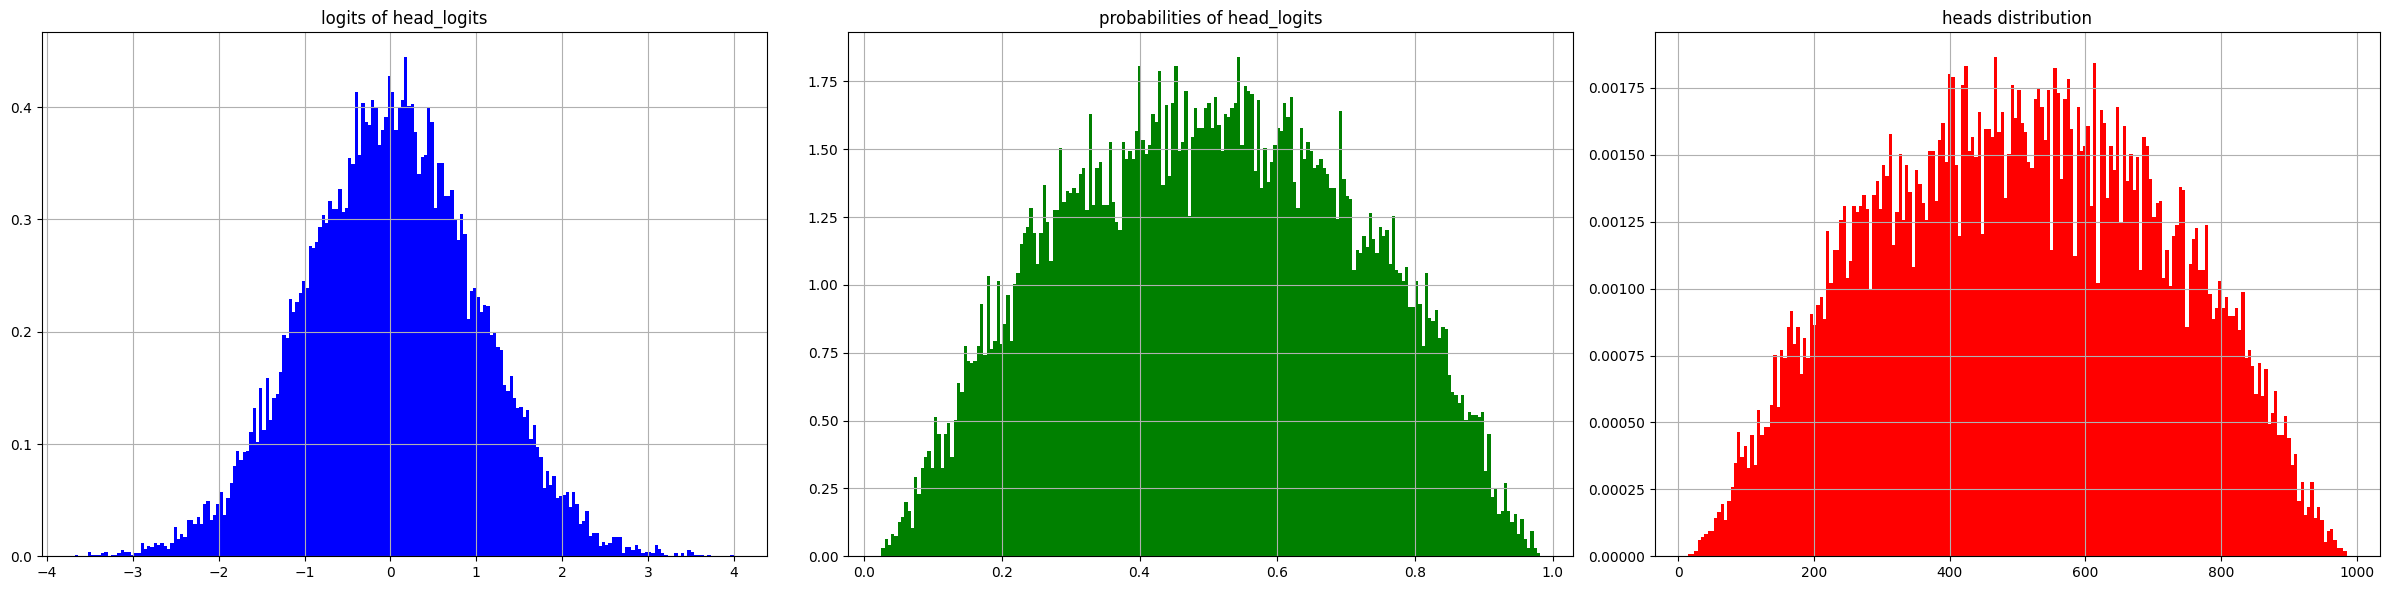

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))

ax0.hist(dict(trace.nodes.items())["head_logits"]["value"].numpy(),
         200, density=True, histtype='bar', color="blue")
ax0.set_title('logits of head_logits')
ax0.grid()

ax1.hist(
    sigma(
        dict(trace.nodes.items())["head_logits"]["value"].numpy()
    ),
    200, density=True, histtype='bar', color="green")
ax1.set_title('probabilities of head_logits')
ax1.grid()

ax2.hist(dict(trace.nodes.items())["coins_outcomes"]["value"].numpy(),
         200, density=True, histtype='bar', color="red")
ax2.set_title('heads distribution')
ax2.grid()

fig.tight_layout()
plt.show()